# GEX Alpha Strategy - Investor Charts

This notebook generates publication-quality charts for investor presentations.

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11

# Colors
COLORS = {
    'primary': '#2563eb',
    'win': '#22c55e',
    'loss': '#ef4444',
    'accent': '#f59e0b',
    'neutral': '#6b7280'
}

# Load backtest data
with open('../output/strangle_detailed_analysis.json', 'r') as f:
    data = json.load(f)

print(f"Loaded data: {data['summary_statistics']['total_trades']} trades")
print(f"Win rate: {data['summary_statistics']['win_rate']*100:.1f}%")

Loaded data: 42 trades
Win rate: 81.0%


## Chart 1: Key Performance Metrics

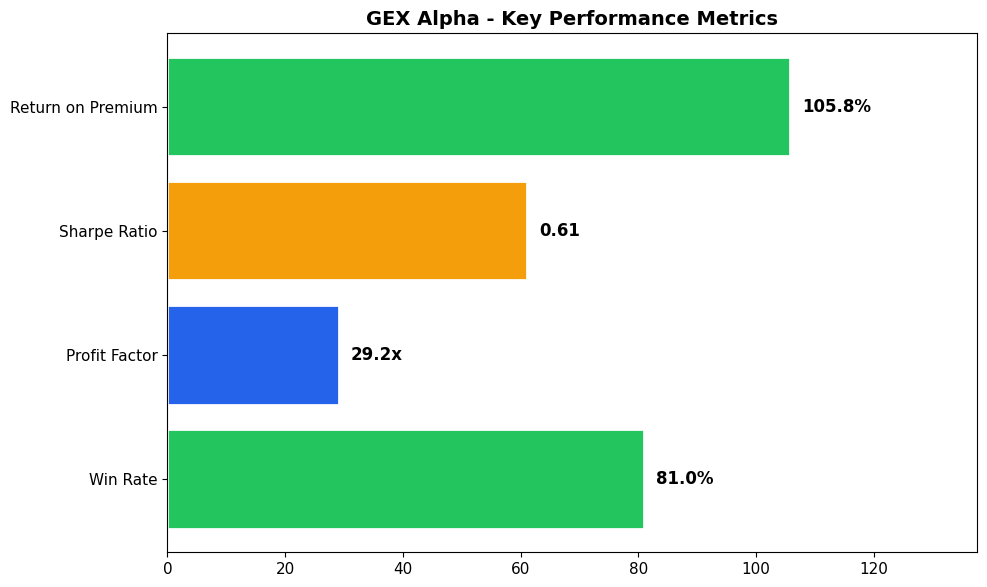

In [2]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Win Rate', 'Profit Factor', 'Sharpe Ratio', 'Return on Premium']
values = [
    data['summary_statistics']['win_rate'] * 100,
    min(data['risk_metrics']['profit_factor'], 30),
    data['risk_metrics']['sharpe_ratio'] * 100,
    data['summary_statistics']['return_on_premium'] * 100
]
display_labels = [
    f"{data['summary_statistics']['win_rate']*100:.1f}%",
    f"{data['risk_metrics']['profit_factor']:.1f}x",
    f"{data['risk_metrics']['sharpe_ratio']:.2f}",
    f"{data['summary_statistics']['return_on_premium']*100:.1f}%"
]

colors = [COLORS['win'], COLORS['primary'], COLORS['accent'], COLORS['win']]
bars = ax.barh(metrics, values, color=colors, edgecolor='white', linewidth=2)

for bar, label in zip(bars, display_labels):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
           label, va='center', fontweight='bold', fontsize=12)

ax.set_title('GEX Alpha - Key Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(values) * 1.3)
plt.tight_layout()
plt.savefig('charts/01_performance_metrics.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Chart 2: Win/Loss Distribution

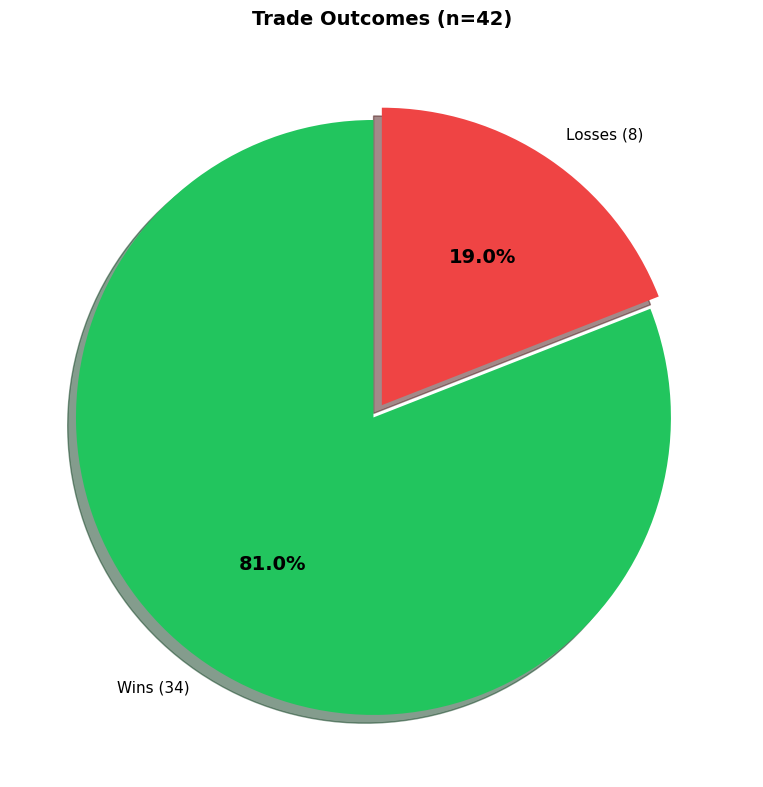

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))

wins = data['summary_statistics']['winning_trades']
losses = data['summary_statistics']['losing_trades']

wedges, texts, autotexts = ax.pie(
    [wins, losses],
    labels=[f'Wins ({wins})', f'Losses ({losses})'],
    colors=[COLORS['win'], COLORS['loss']],
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0),
    shadow=True
)

for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

ax.set_title(f'Trade Outcomes (n={wins+losses})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('charts/02_win_loss_pie.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Chart 3: Simulated Equity Curve

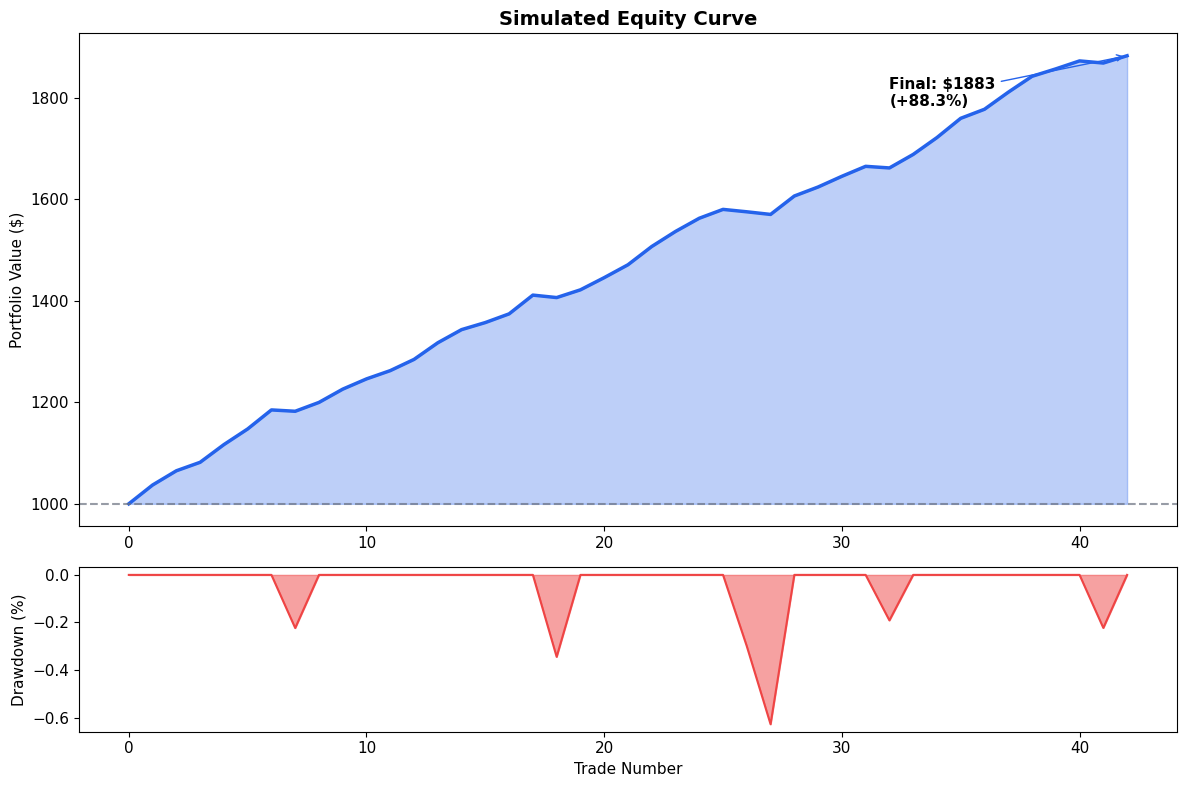

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])

n_trades = data['summary_statistics']['total_trades']
win_rate = data['summary_statistics']['win_rate']
avg_win = data['risk_metrics']['average_win']
avg_loss = data['risk_metrics']['average_loss']

np.random.seed(42)
equity = [1000]
for i in range(n_trades):
    if np.random.random() < win_rate:
        pnl = avg_win * (0.5 + np.random.random())
    else:
        pnl = avg_loss * (0.5 + np.random.random())
    equity.append(equity[-1] + pnl)

# Equity curve
ax1.fill_between(range(len(equity)), 1000, equity, alpha=0.3, color=COLORS['primary'])
ax1.plot(range(len(equity)), equity, color=COLORS['primary'], linewidth=2.5)
ax1.axhline(y=1000, color=COLORS['neutral'], linestyle='--', alpha=0.7)
ax1.set_ylabel('Portfolio Value ($)')
ax1.set_title('Simulated Equity Curve', fontsize=14, fontweight='bold')

final_val = equity[-1]
ax1.annotate(f'Final: ${final_val:.0f}\n(+{(final_val-1000)/10:.1f}%)',
            xy=(n_trades, final_val), xytext=(n_trades-10, final_val-100),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color=COLORS['primary']))

# Drawdown
peak = np.maximum.accumulate(equity)
drawdown = [(e - p) / p * 100 for e, p in zip(equity, peak)]

ax2.fill_between(range(len(equity)), 0, drawdown, alpha=0.5, color=COLORS['loss'])
ax2.plot(range(len(equity)), drawdown, color=COLORS['loss'], linewidth=1.5)
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Trade Number')

plt.tight_layout()
plt.savefig('charts/03_equity_curve.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Chart 4: Monthly Performance

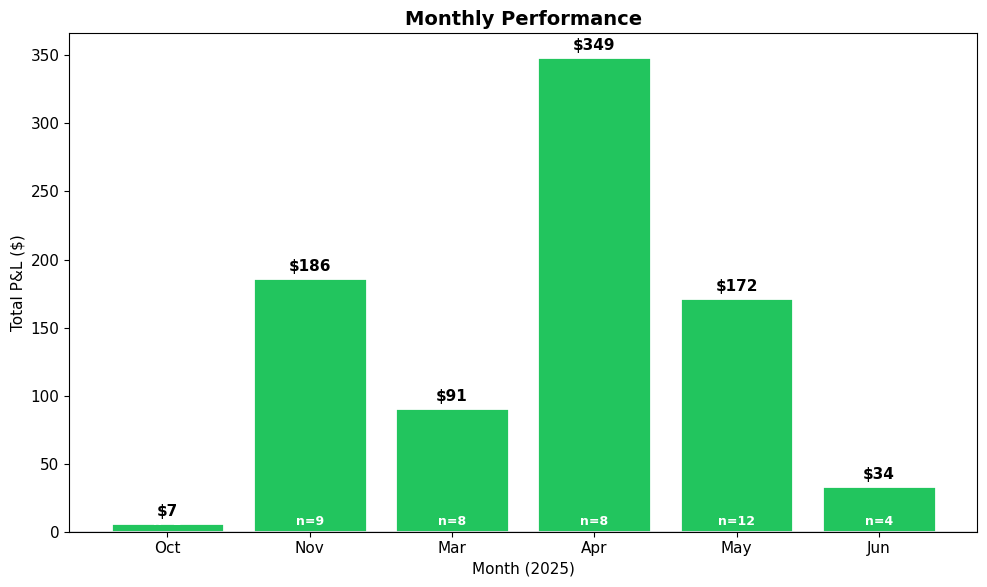

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

monthly = data['time_analysis']['monthly_performance']
month_names = {3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 10: 'Oct', 11: 'Nov'}

months = []
pnls = []
counts = []

for key, val in sorted(monthly.items()):
    month_num = int(key.split('_')[1])
    if month_num in month_names:
        months.append(month_names[month_num])
        pnls.append(val['total_pnl'])
        counts.append(val['trade_count'])

colors = [COLORS['win'] if p > 0 else COLORS['loss'] for p in pnls]
bars = ax.bar(months, pnls, color=colors, edgecolor='white', linewidth=2)

for bar, pnl, count in zip(bars, pnls, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
           f'${pnl:.0f}', ha='center', fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2, 5,
           f'n={count}', ha='center', fontsize=9, color='white', fontweight='bold')

ax.axhline(y=0, color=COLORS['neutral'], linestyle='-', linewidth=1)
ax.set_ylabel('Total P&L ($)')
ax.set_xlabel('Month (2025)')
ax.set_title('Monthly Performance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('charts/04_monthly_performance.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Chart 5: GEX Concept Illustration

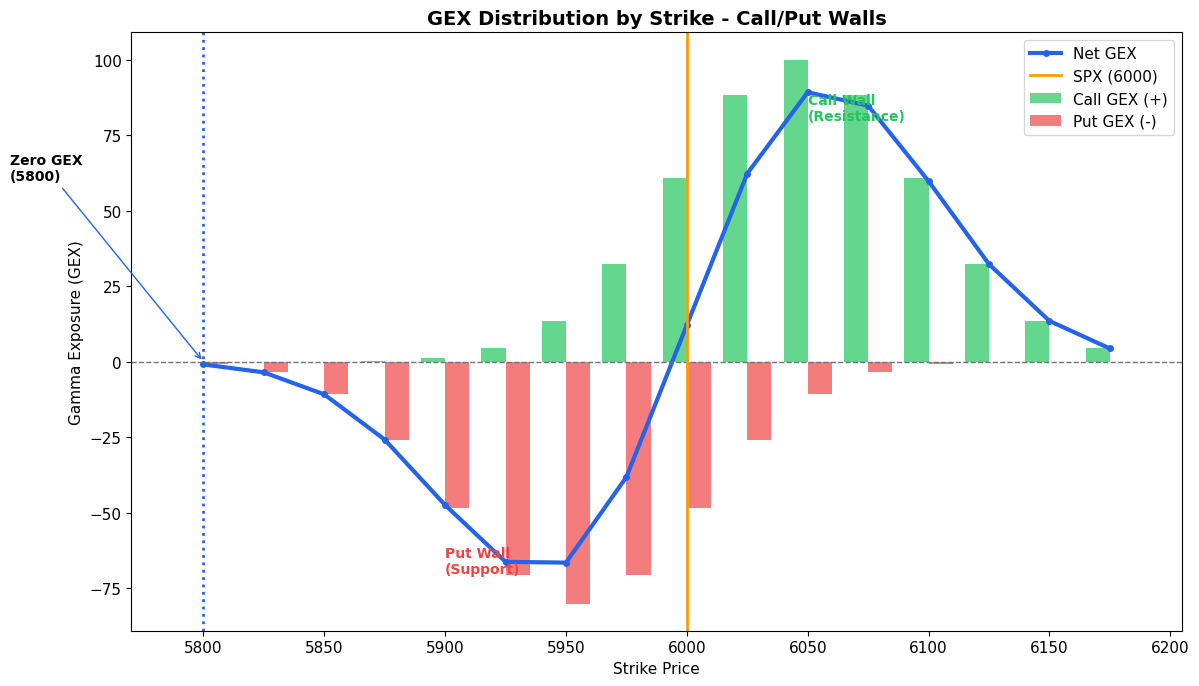

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

strikes = np.arange(5800, 6200, 25)
current_price = 6000

# Simulate GEX distribution
call_gex = np.exp(-((strikes - current_price - 50) ** 2) / 5000) * 100
put_gex = -np.exp(-((strikes - current_price + 50) ** 2) / 5000) * 80
net_gex = call_gex + put_gex

ax.bar(strikes - 5, call_gex, width=10, color=COLORS['win'], alpha=0.7, label='Call GEX (+)')
ax.bar(strikes + 5, put_gex, width=10, color=COLORS['loss'], alpha=0.7, label='Put GEX (-)')
ax.plot(strikes, net_gex, color=COLORS['primary'], linewidth=3, marker='o', markersize=4, label='Net GEX')

ax.axhline(y=0, color=COLORS['neutral'], linestyle='--', linewidth=1)
ax.axvline(x=current_price, color=COLORS['accent'], linestyle='-', linewidth=2, label=f'SPX ({current_price})')

# Find zero GEX
zero_idx = np.argmin(np.abs(net_gex))
zero_gex = strikes[zero_idx]
ax.axvline(x=zero_gex, color=COLORS['primary'], linestyle=':', linewidth=2)
ax.annotate(f'Zero GEX\n({zero_gex})', xy=(zero_gex, 0), xytext=(zero_gex-80, 60),
           fontsize=10, fontweight='bold',
           arrowprops=dict(arrowstyle='->', color=COLORS['primary']))

# Annotate walls
ax.annotate('Call Wall\n(Resistance)', xy=(6050, 80), fontsize=10, fontweight='bold', color=COLORS['win'])
ax.annotate('Put Wall\n(Support)', xy=(5900, -70), fontsize=10, fontweight='bold', color=COLORS['loss'])

ax.set_xlabel('Strike Price')
ax.set_ylabel('Gamma Exposure (GEX)')
ax.set_title('GEX Distribution by Strike - Call/Put Walls', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('charts/05_gex_concept.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Chart 6: Benchmark Comparison

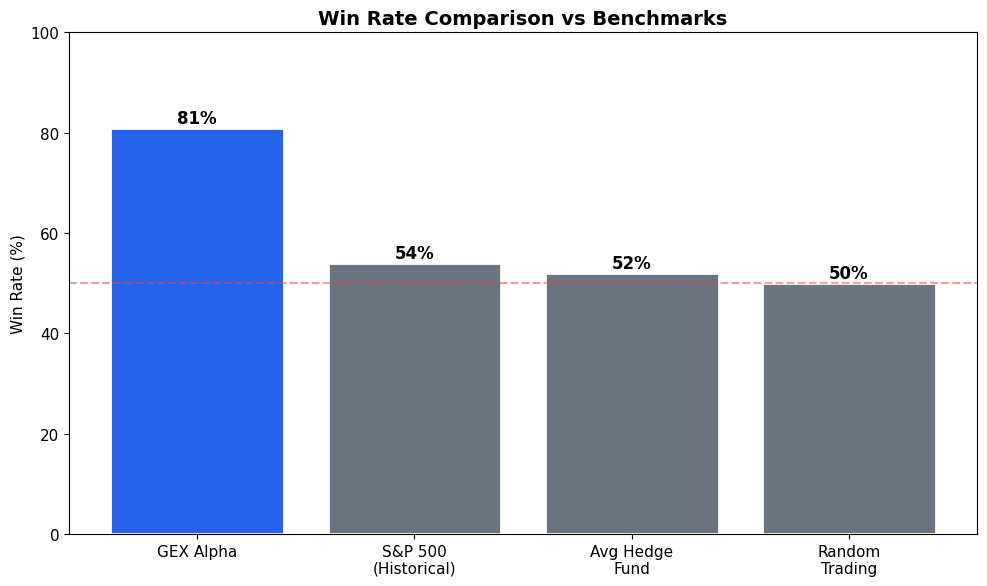

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

strategies = ['GEX Alpha', 'S&P 500\n(Historical)', 'Avg Hedge\nFund', 'Random\nTrading']
win_rates = [81, 54, 52, 50]

colors = [COLORS['primary'], COLORS['neutral'], COLORS['neutral'], COLORS['neutral']]
bars = ax.bar(strategies, win_rates, color=colors, edgecolor='white', linewidth=2)

for bar, wr in zip(bars, win_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
           f'{wr}%', ha='center', fontweight='bold', fontsize=12)

ax.axhline(y=50, color=COLORS['loss'], linestyle='--', alpha=0.5, label='Random (50%)')
ax.set_ylabel('Win Rate (%)')
ax.set_title('Win Rate Comparison vs Benchmarks', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('charts/06_benchmark_comparison.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Chart 7: Risk/Reward Analysis

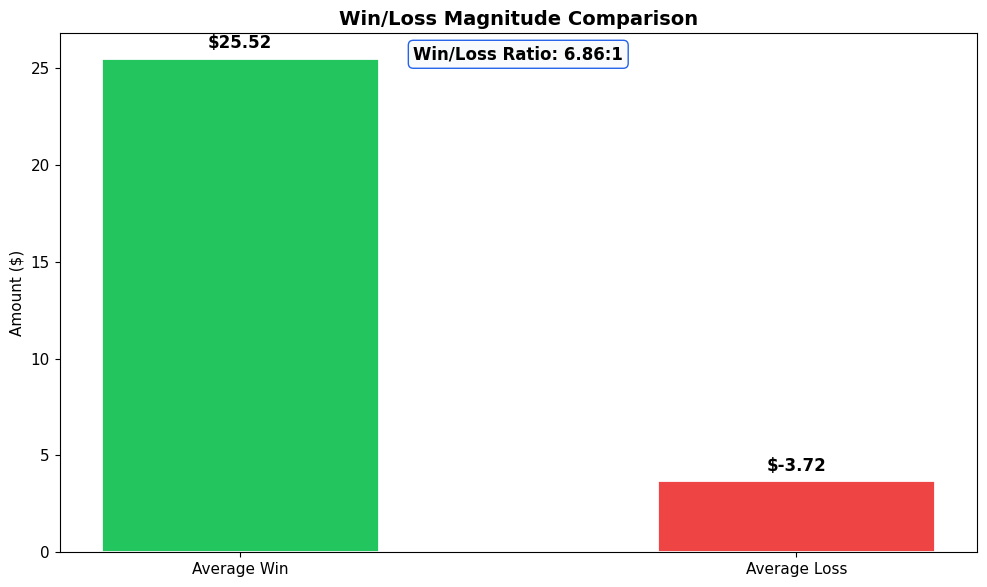

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Average Win', 'Average Loss']
amounts = [data['risk_metrics']['average_win'], abs(data['risk_metrics']['average_loss'])]
colors = [COLORS['win'], COLORS['loss']]

bars = ax.bar(categories, amounts, color=colors, edgecolor='white', linewidth=2, width=0.5)

for bar, amt, orig in zip(bars, amounts, [data['risk_metrics']['average_win'], data['risk_metrics']['average_loss']]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
           f'${orig:.2f}', ha='center', fontweight='bold', fontsize=12)

ratio = data['risk_metrics']['win_loss_ratio']
ax.annotate(f'Win/Loss Ratio: {ratio:.2f}:1',
           xy=(0.5, 0.95), xycoords='axes fraction',
           ha='center', fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='#f8fafc', edgecolor=COLORS['primary']))

ax.set_ylabel('Amount ($)')
ax.set_title('Win/Loss Magnitude Comparison', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('charts/07_risk_reward.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Summary

All charts have been saved to the `charts/` directory:
- `01_performance_metrics.png`
- `02_win_loss_pie.png`
- `03_equity_curve.png`
- `04_monthly_performance.png`
- `05_gex_concept.png`
- `06_benchmark_comparison.png`
- `07_risk_reward.png`

In [9]:
# List generated charts
import os
print("Generated charts:")
for f in sorted(os.listdir('charts')):
    if f.endswith('.png'):
        size = os.path.getsize(os.path.join('charts', f))
        print(f"  - {f} ({size:,} bytes)")

Generated charts:
  - 01_performance_metrics.png (51,600 bytes)
  - 02_win_loss_pie.png (97,598 bytes)
  - 03_equity_curve.png (128,739 bytes)
  - 04_monthly_performance.png (60,178 bytes)
  - 05_gex_concept.png (151,814 bytes)
  - 06_benchmark_comparison.png (64,375 bytes)
  - 07_risk_reward.png (53,316 bytes)
